In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import textwrap
import seaborn as sns
import seaborn.objects as so
from generative_social_choice.utils.helper_functions import get_base_dir_path
from generative_social_choice.utils.helper_functions import (
    detect_dataset,
)

# Select which data to load

In [4]:
PLOT_NUMBER = 1  # options: 1 or 2

In [5]:
EXPERIMENT_FOLDERS = []
BASE_PATH = get_base_dir_path() / "experiments/approval_query_eval"
CHANGEMYVIEW_FOLDER = BASE_PATH / "predict_cmv_votes"
POLIS_FOLDER = BASE_PATH / "predict_polis_votes"

if PLOT_NUMBER == 1:
    # Use a single cmv dataset (we use 4 in the main body of the paper) and all Polis datasets
    for folder in os.listdir(CHANGEMYVIEW_FOLDER):
        if (
            "2_final" in folder
        ):  # submitted paper uses "mainbody" data, arXiv version uses 2_final
            EXPERIMENT_FOLDERS.append("predict_cmv_votes/" + folder)
    for folder in os.listdir(POLIS_FOLDER):
        if "final" in folder:
            EXPERIMENT_FOLDERS.append("predict_polis_votes/" + folder)

elif PLOT_NUMBER == 2:
    # use all cmv datasets (we care about robustness across random seeds) and no polis
    for folder in os.listdir(CHANGEMYVIEW_FOLDER):
        if "final" in folder:
            EXPERIMENT_FOLDERS.append("predict_cmv_votes/" + folder)

# Load data

In [6]:
logs = []
for folder in EXPERIMENT_FOLDERS:
    raw_df = pd.read_csv(BASE_PATH / folder / "logs.csv", index_col=0)

    # for actual data
    raw_df["vote_match"] = (raw_df["true_vote"] == raw_df["llm_vote"]).astype(int)
    raw_df["dataset"] = detect_dataset(folder)

    # append to logs
    logs.extend([raw_df])

# concat all logs into one df
df = pd.concat(logs, ignore_index=True)
df.rename(columns={"subject": "query2_prompt_type"}, inplace=True)

# Generate summary statistics

In [7]:
if PLOT_NUMBER == 1:
    df["num_given_comments"] = df["num_given_comments"].fillna(0)
    df["num_given_votes"] = df["num_given_votes"].fillna(0)
    grouped = (
        df.groupby(["dataset", "num_given_comments", "num_given_votes", "agent_id"])[
            "vote_match"
        ]
        .mean()
        .reset_index()
    )
    mean_median = grouped.groupby(["dataset", "num_given_comments", "num_given_votes"])[
        "vote_match"
    ].agg(["mean", "median"])

elif PLOT_NUMBER == 2:
    grouped = (
        df.groupby(["dataset", "seed", "agent_id"])["vote_match"].mean().reset_index()
    )
    mean_median = grouped.groupby(["dataset", "seed"])["vote_match"].agg(
        ["mean", "median"]
    )
mean_median

mean  median
dataset      num_given_comments num_given_votes                  
bowlinggreen 1.0                2.0              0.570000    0.55
             3.0                20.0             0.722500    0.70
changemyview 0.0                0.0              0.840000    0.90
minimumwage  1.0                2.0              0.692308    0.70

# Generate plots

/tmp/ipykernel_1262447/1414054237.py:60: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


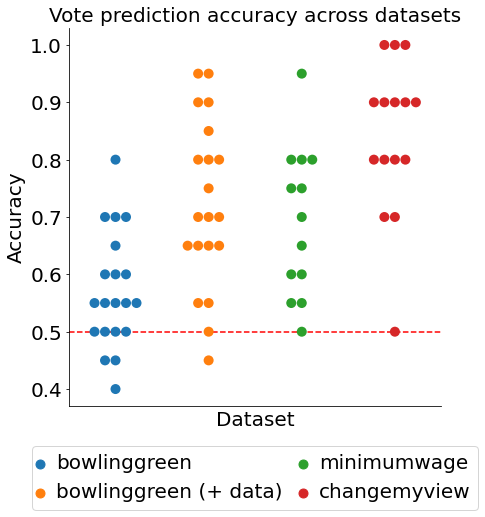

In [8]:
if PLOT_NUMBER == 1:
    df["x_values"] = (
        df["dataset"].astype(str)
        + ", "
        + df["num_given_comments"].astype(int).astype(str)
        + ", "
        + df["num_given_votes"].astype(int).astype(str)
    )
    df["x_values"].replace(
        {
            "changemyview, 0, 0": "changemyview",
            "minimumwage, 1, 2": "minimumwage",
            "bowlinggreen, 1, 2": "bowlinggreen",
            "bowlinggreen, 3, 20": "bowlinggreen (+ data)",
        },
        inplace=True,
    )

    order = ["bowlinggreen", "bowlinggreen (+ data)", "minimumwage", "changemyview"]
    df["x_values_order"] = df["x_values"].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )

    ncol_legend = 2
    title = "Vote prediction accuracy across datasets"
    xlabel = "Dataset"
    vertical_legend_offset = -0.3

elif PLOT_NUMBER == 2:
    df["x_values"] = f"seed " + df["seed"].astype(int).astype(str) + ""

    df["x_values_order"] = df["x_values"]

    ncol_legend = 5
    title = "Vote prediction accuracy across seeds"
    xlabel = "Seed"
    vertical_legend_offset = -0.2


# Create a new column with desired order


avg_vote_match = (
    df.groupby(["x_values_order", "agent_id"])["vote_match"].mean().reset_index()
)


plot = sns.catplot(
    data=avg_vote_match,
    x="x_values_order",
    y="vote_match",
    hue="x_values_order",
    kind="swarm",
    height=6,
    aspect=1,
    size=10,
)

plot.ax.axhline(0.5, ls="--", color="red")  # Add horizontal line at 0.5 vote match
plt.xticks([], [])
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel(xlabel, fontsize=20)
plt.title(title, fontsize=20)
plot.ax.tick_params(axis="y", labelsize=20)

legend = plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, vertical_legend_offset),
    ncol=ncol_legend,
    fontsize=20,
    markerscale=1.5,
    columnspacing=1,
    handlelength=0,
)


plt.savefig(
    f"approval_query_swarm_{'datasets' if PLOT_NUMBER == 1 else 'seeds'}.pdf",
    bbox_inches="tight",
)

In [166]:
avg_vote_match
unique_agents = avg_vote_match.groupby("x_values_order")["agent_id"].nunique()
unique_agents

x_values_order
seed 0    16
seed 1    15
seed 2    15
seed 3    15
seed 4    15
Name: agent_id, dtype: int64

In [169]:
avg_vote_match.agg(["mean", "median", "std"])

,agent_id,vote_match
mean,5.120905e+07,0.867105
median,4.946697e+07,0.900000
std,2.707586e+07,0.110016
